In [1]:
import os
CODE_DIR = 'home/ubuntu/stylegan2-encoder-pytorch'
os.chdir(f'/{CODE_DIR}')
import os
import random
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

from model import Generator, Encoder
from train_encoder import VGGLoss

import matplotlib.pyplot as plt


def image2tensor(image):
    image = torch.FloatTensor(image).permute(2,0,1).unsqueeze(0)/255.
    return (image-0.5)/0.5

def tensor2image(tensor):
    tensor = tensor.clamp_(-1., 1.).detach().squeeze().permute(1,2,0).cpu().numpy()
    return tensor*0.5 + 0.5

def imshow(img, size=5, cmap='jet'):
    plt.figure(figsize=(size,size))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()


device = 'cuda'
image_size=256


[generator loaded]
[encoder loaded]
generated samples:


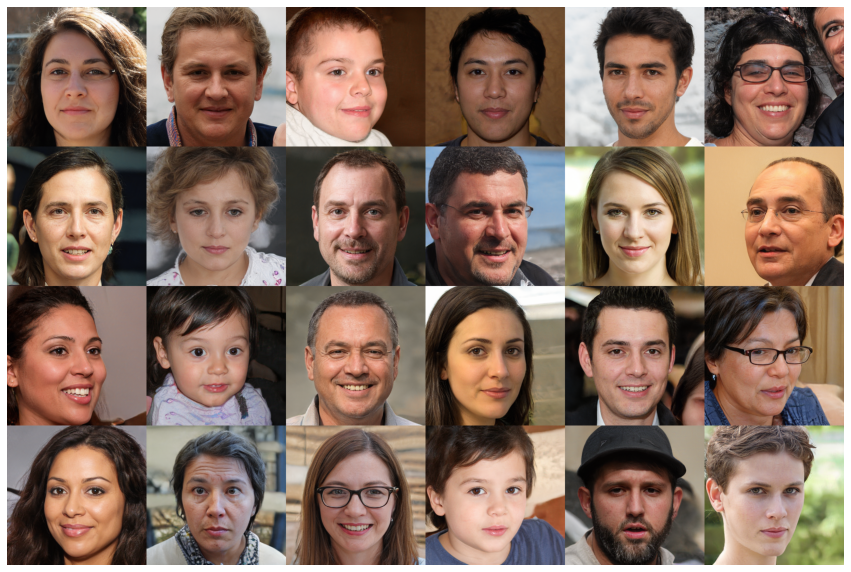

In [2]:
g_model_path = '/home/ubuntu/gen.pt'
g_ckpt = torch.load(g_model_path, map_location=device)

latent_dim = g_ckpt['args'].latent

generator = Generator(image_size, latent_dim, 8).to(device)
generator.load_state_dict(g_ckpt["g_ema"], strict=False)
generator.eval()
print('[generator loaded]')

e_model_path = '/home/ubuntu/encoder.pt'
e_ckpt = torch.load(e_model_path, map_location=device)

encoder = Encoder(image_size, latent_dim).to(device)
encoder.load_state_dict(e_ckpt['e'])
encoder.eval()
print('[encoder loaded]')

truncation = 0.7
trunc = generator.mean_latent(4096).detach().clone()

with torch.no_grad():
    latent = generator.get_latent(torch.randn(4*6, latent_dim, device=device))
    imgs_gen, _ = generator([latent],
                              truncation=truncation,
                              truncation_latent=trunc,
                              input_is_latent=True,
                              randomize_noise=True)

    result = []
    for row in imgs_gen.chunk(4, dim=0):
        result.append(torch.cat([img for img in row], dim=2))
    result = torch.cat(result, dim=1)
    print('generated samples:')
    imshow(tensor2image(result), size=15)

initial projections:


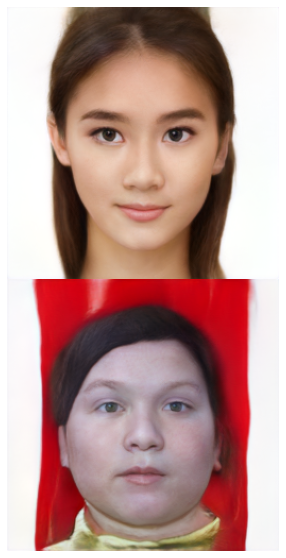

In [30]:
batch_size = 2

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root='/home/ubuntu/bp4_1', transform=transform)
loader = iter(torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True))

imgs, _ = next(loader)
imgs = imgs.to(device)

with torch.no_grad():
    z0 = encoder(imgs)
    imgs_gen, _ =  generator([z0], 
                           input_is_latent=True,
                           truncation=truncation,
                           truncation_latent=trunc,
                           randomize_noise=False)

imgs_real = torch.cat([img for img in imgs], dim=1)
imgs_fakes = torch.cat([img_gen for img_gen in imgs_gen], dim=1)

print('initial projections:')
imshow(tensor2image(torch.cat([imgs_fakes], dim=2)),10)

step:100, loss:1.2409476041793823


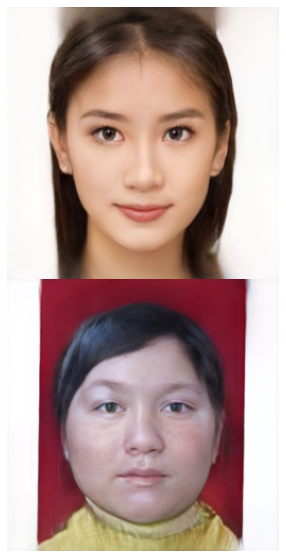

step:200, loss:1.0614287853240967


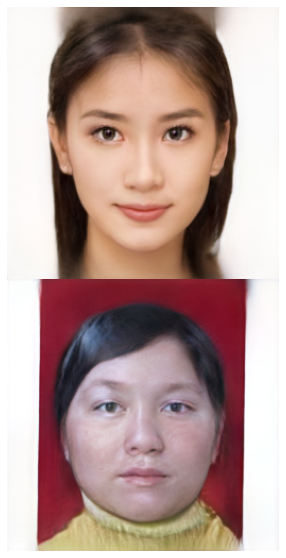

step:300, loss:0.9707698822021484


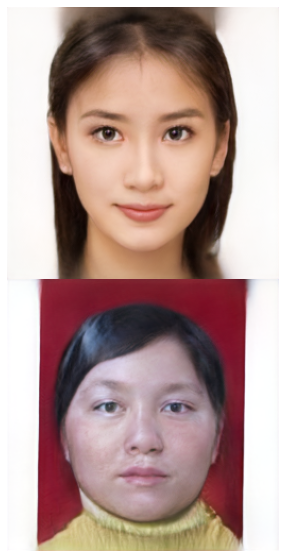

step:400, loss:0.9014989733695984


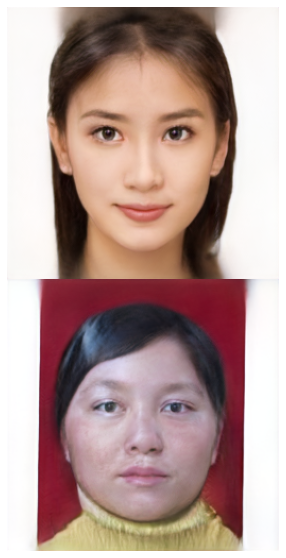

In [ ]:
vgg_loss = VGGLoss(device)

z = z0.detach().clone()

z.requires_grad = True
optimizer = torch.optim.Adam([z], lr=0.01)

for step in range(500):
    imgs_gen, _ = generator([z], 
                           input_is_latent=True, 
                           truncation=truncation,
                           truncation_latent=trunc, 
                           randomize_noise=False)

    z_hat = encoder(imgs_gen)
    
    loss = F.mse_loss(imgs_gen, imgs) + vgg_loss(imgs_gen, imgs) + F.mse_loss(z0, z_hat)*2.0
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 
    
    if (step+1)%100 == 0:
        print(f'step:{step+1}, loss:{loss.item()}')
        imgs_fakes = torch.cat([img_gen for img_gen in imgs_gen], dim=1)        
        imshow(tensor2image(torch.cat([imgs_fakes], dim=2)),10)

In [ ]:
n_interp = 3
latent_interp = torch.zeros(1, z.shape[1], z.shape[2]).to(device)

with torch.no_grad():
   # for j in range(n_interp):0
        #latent_interp[0] = (float(1) * z[0] + float(1) * z[1]+ float(1) * z[2]+ float(1) * z[3]+ float(1) * z[4])/(5)
        latent_interp[0] = (float(1) * z[0] + float(1) * z[1])/(2)
    
        imgs_gen, _ = generator([latent_interp],
                                input_is_latent=True,                                     
                                truncation=truncation,
                                truncation_latent=trunc,
                                randomize_noise=False)

imshow(tensor2image(torch.cat([img_gen for img_gen in imgs_gen], dim=2)), 20)

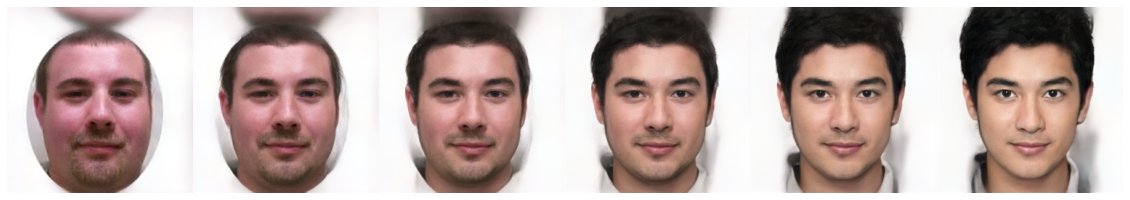

In [29]:
n_interp = 6
latent_interp = torch.zeros(n_interp, z.shape[1], z.shape[2]).to(device)

with torch.no_grad():
    for j in range(n_interp):
        latent_interp[j] = (float(n_interp-j-1) * z[0] + float(j) * z[1])/(n_interp-1)
    
        imgs_gen, _ = generator([latent_interp],
                                input_is_latent=True,                                     
                                truncation=truncation,
                                truncation_latent=trunc,
                                randomize_noise=False)

imshow(tensor2image(torch.cat([img_gen for img_gen in imgs_gen], dim=2)), 20)

In [9]:
import torch
torch.cuda.empty_cache()

In [70]:
!python --version

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Python 3.7.10


In [71]:
torch. __version__

'1.7.1'